## Using Bayesian Methods to Optimise Reaction Conditions

## The Problem

In drug discovery, we frequently encounter situations where we need to modify a set of reaction conditions to optimise the yield. In an early discovery program, we may want to scale up a key intermediate to facilitate SAR exploration. In a later stage program, a process chemist may want to optimise a reaction for multi-kilo scale manufacture of the drug substance. A variety of strategies, ranging from intuition to design of experiments (DOE), are used to facilitate optimisation.

Traditional Design of Experiments (DoE) methodologies become increasingly impractical as the number of experimental factors and their levels grow, leading to an exponential increase in required experiments. **This results in excessive resource consumption—time, materials, and labor—while also complicating data analysis due to large datasets and potential confounding effects.**

To address this challenge, **Bayesian Optimization (BO)** was implemented as a key strategy. Bayesian optimisation is a technique that balances exploration and exploitation to identify optimal solutions. **This approach intelligently prioritizes experimental conditions most likely to yield optimal results, drastically reducing the number of required experiments while accelerating decision-making.**

The primary response variable—**reaction yield**—was used to measure success, reflecting the percentage of the desired product formed under specific conditions. Unlike traditional DoE methods, Bayesian Optimization follows a "learn as we go" approach, dynamically adjusting the experimental plan based on real-time data. This reduces unnecessary experiments and delivers faster, data-driven insights.

In this notebook, we will use BayBE, an optimization library developed by scientists at Merck KGaA in Darmstadt, Germany.

In this example, we will consider a reaction from the SynPlanner video - a Buchwald-Hartwig coupling of a amine and a aryl-bromide.

## Example 1


* In drug discovery, we frequently encounter situations where we need to **modify a set of reaction conditions to optimise the yield**. In an early discovery program, we may want to scale up a key intermediate to facilitate SAR exploration. In a later stage program, a process chemist may want to optimise a reaction for multi-kilo scale manufacture of the drug substance. A variety of strategies, ranging from intuition to design of experiments (DOE), are used to facilitate optimisation.

* An alternative approach is to use **Bayesian optimisation**, a technique that **balances exploration and exploitation** to identify optimal solutions. In this notebook, we will use [BayBE](https://github.com/emdgroup/baybe), an optimization library developed by scientists at Merck KGaA in Darmstadt, Germany.

In this example, we will consider a reaction described in the supporting material of a 2020 paper by [Shields](https://www.nature.com/articles/s41586-021-03213-y) and coworkers from UCLA.

       
<center><img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/bayes/Shields_reaction.png" style="width: 50%; height: 50%"/></center>

We will optimize the 5 parameters shown in blue in the figure above.   Each of these parameters has a set of options available.

<center><img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/bayes/Possible_conditions.png" style="width: 50%; height: 50%"/></center>

* In total, there are 12 * 4 * 4 * 3 * 3 = 1728 possible combinations!

* We would like to identify the optimal conditions while **running only a small number of experiments**. Fortunately, Shields and coworkers investigated all 1728 combinations and provided a table with the conditions and corresponding yields.

* **In this notebook, we will simulate a Bayesian optimisation process.** We will begin by **identifying 10 initial reaction conditions.** In practice, we would then run experiments to evaluate these conditions and record the corresponding reaction yields. However, in this case, we will look up the yields in a table. With the conditions and yields in hand, we can **build a Bayesian model** and use this model to **select another 5 reaction conditions**. We will then look up the yields for the 5 conditions and use this information to update the model. We will** repeat this process through 5 rounds of optimisation** and examine the reaction yields for each optimisation cycle.

# Using Bayesian Methods to Optimise Reaction Conditions

In [ ]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 66.0 MB/s eta 0:00:00


In [ ]:
%pip install useful_rdkit_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
%pip install numpy matplotlib

### EXAMPLE 2:  Buchwald-Hartwig Coupling


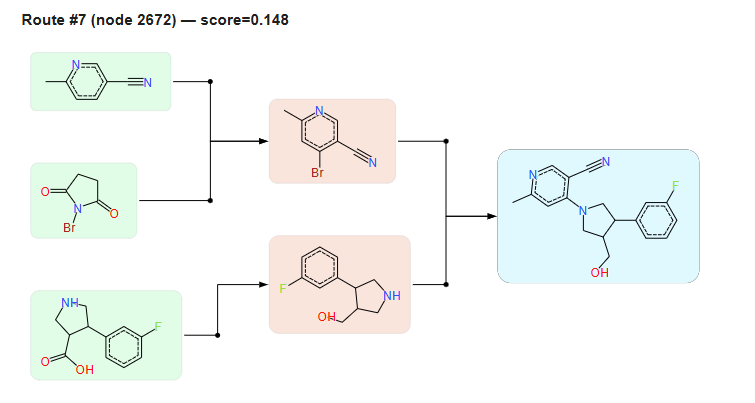

In [ ]:
#@title Colab: 2D molecule sketcher + "Save 2D structure as SMILES"
from IPython.display import HTML, display
#Javascript
html = r"""
<div id="mol-sketcher-root" style="font-family:system-ui,-apple-system,Segoe UI,Roboto,Inter,Helvetica,Arial,sans-serif; line-height:1.35;">
  <h3 style="margin:0 0 8px;">2D Molecular Sketcher</h3>
  <div id="status" style="font-size:12px;color:#666;margin:0 0 8px;">Loading editor…</div>

  <!-- Editor goes here -->
  <div id="jsme_container" style="width:720px;height:480px;border:1px solid #e3e3e3;border-radius:8px;overflow:hidden;"></div>

  <div style="margin-top:10px; display:flex; gap:8px; align-items:center; flex-wrap:wrap;">
    <button id="saveBtn" style="padding:8px 12px;border:1px solid #ccc;border-radius:8px;background:#fafafa;cursor:pointer;">
      Save 2D structure as SMILES
    </button>
    <span id="savedBadge" style="display:none;font-size:12px;color:#2e7d32;">Saved ✓</span>
  </div>

  <div style="margin-top:10px;">
    <div style="font-size:12px;color:#444;margin-bottom:4px;">SMILES</div>
    <pre id="smiles_output" style="min-height:1.6em;padding:8px;border:1px dashed #d0d0d0;border-radius:8px;background:#fcfcfc;white-space:pre-wrap;word-break:break-word;margin:0;"></pre>
  </div>
</div>

<script>
// -------------- Configuration (optional) ----------------
// You can pre-load a structure by putting a SMILES here, e.g. "CC(=O)Oc1ccccc1C(=O)O"
const INITIAL_SMILES = "";

// -------------- JSME loader with fallback CDNs ----------
(function() {
  // Define jsmeOnLoad **before** loading the script — JSME will call this automatically.
  window.jsmeOnLoad = function() {
    const status = document.getElementById('status');
    try {
      // Make editor width responsive-ish based on the output area.
      const hostWidth = Math.max(520, Math.min(860, document.getElementById('mol-sketcher-root').clientWidth || 720));
      const widthPx  = hostWidth + "px";
      const heightPx = "480px";

      // Options: stereo & auto E/Z, show implicit H on heteroatoms, allow zoom, modern UI.
      const opts = { "options": "newlook,stereo,autoez,hydrogens,zoom" };

      // Create the editor
      window.jsmeApplet = new JSApplet.JSME("jsme_container", widthPx, heightPx, opts);

      // Optionally load an initial molecule
      if (INITIAL_SMILES && typeof INITIAL_SMILES === "string") {
        try { window.jsmeApplet.readGenericMolecularInput(INITIAL_SMILES); } catch(e) {}
      }

      // Wire up the Save button
      const saveBtn = document.getElementById("saveBtn");
      const out = document.getElementById("smiles_output");
      const badge = document.getElementById("savedBadge");

      saveBtn.addEventListener("click", () => {
        try {
          const smiles = window.jsmeApplet.smiles() || "";
          out.textContent = smiles;
          // Tiny “saved” tick feedback
          badge.style.display = "inline";
          setTimeout(() => { badge.style.display = "none"; }, 1200);
        } catch(err) {
          out.textContent = "[Error reading SMILES: " + (err && err.message ? err.message : err) + "]";
        }
      });

      status.textContent = "Editor ready. Draw your molecule, then click “Save 2D structure as SMILES”.";
      status.style.color = "#2e7d32";
    } catch (e) {
      status.textContent = "Editor failed to initialize: " + e;
      status.style.color = "#b00020";
    }
  };

  // Load JSME from a stable source, with two fallbacks.
  const sources = [
    "https://jsme-editor.github.io/dist/jsme/jsme.nocache.js",
    "https://cdn.jsdelivr.net/npm/jsme-editor@2024.4.29/dist/jsme/jsme.nocache.js",
    "https://unpkg.com/jsme-editor@2024.4.29/dist/jsme/jsme.nocache.js"
  ];
  const status = document.getElementById('status');

  function loadScript(i) {
    if (i >= sources.length) {
      status.textContent = "Could not load the JSME script from any source.";
      status.style.color = "#b00020";
      return;
    }
    const s = document.createElement("script");
    s.type = "text/javascript";
    s.src = sources[i];
    s.onload = function() { /* JSME will call window.jsmeOnLoad() on its own. */ };
    s.onerror = function() { loadScript(i + 1); };
    document.head.appendChild(s);
    status.textContent = "Loading editor… (" + sources[i] + ")";
  }
  loadScript(0);
})();
</script>
"""

display(HTML(html))


RDKit: 2025.09.1


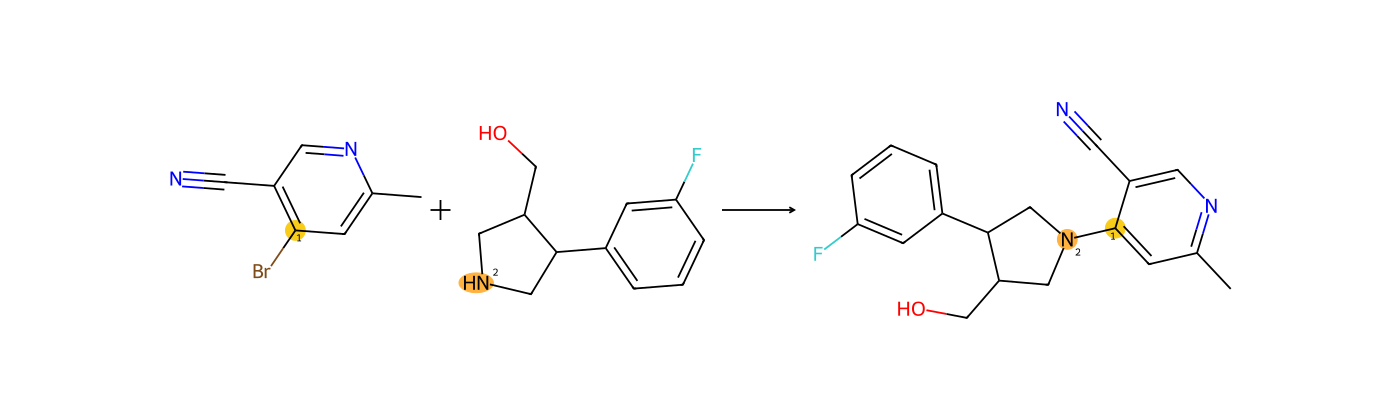

✅ Wrote 'reaction_highlight.svg' (vector) and 'reaction_highlight.png' (hi-res PNG).


In [ ]:
#@title Displaying atom maps and highlighting with reactions
# adapted from https://greglandrum.github.io/rdkit-blog/posts/2025-10-17-displaying-atom-maps-with-reactions.html

from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display, Image as IPyImage
import rdkit
print("RDKit:", rdkit.__version__)

# --- Your reactants ---
r1 = Chem.MolFromSmiles("OCC1CNCC1c2cccc(F)c2")   # secondary amine (has N–H)
r2 = Chem.MolFromSmiles("Cc1cc(Br)c(C#N)cn1")     # aryl bromide

# --- Buchwald–Hartwig amination SMARTS (map only atoms that persist; no map on Br) ---
sma = "[c:1]-Br.[N;H1:2]>>[c:1]-[N:2]"
rxn = rdChemReactions.ReactionFromSmarts(sma)

# --- Run reaction; try both orders if needed ---
prods = rxn.RunReactants((r1, r2))
reacts = (r1, r2)
if not prods:
    prods = rxn.RunReactants((r2, r1))
    reacts = (r2, r1)
if not prods:
    raise ValueError("Reaction SMARTS did not match these reactants. "
                     "Consider relaxing the SMARTS (e.g. [N;H1,H0:2]).")

# --- Helper: build a draw-ready reaction with reactant-based highlights (Greg’s approach) ---
def prepare_draw_reaction(rxn, reacts, prods, includeAtomMaps=True, mapAllAtoms=False):
    reacts = [Chem.Mol(r) for r in reacts]
    prods  = [Chem.Mol(p) for p in prods]
    negVal = -1
    if mapAllAtoms:
        for prod in prods:
            for at in prod.GetAtoms():
                if at.HasProp('old_mapno'):
                    negVal = min(negVal, -1 * at.GetIntProp('old_mapno')) - 1
    # transfer mapping/meta from product atoms to product and corresponding reactant atoms
    for prod in prods:
        for at in prod.GetAtoms():
            pd = at.GetPropsAsDict()
            mno = pd.get('old_mapno', 0 if not mapAllAtoms else negVal)
            if mno != 0:
                rat = reacts[pd['react_idx']].GetAtomWithIdx(pd['react_atom_idx'])
                for tat in (at, rat):
                    tat.SetAtomMapNum(mno)
                    if includeAtomMaps:
                        tat.SetProp('atomNote', str(mno))
    nrxn = rdChemReactions.ChemicalReaction()
    for r in reacts: nrxn.AddReactantTemplate(r)
    for p in prods:  nrxn.AddProductTemplate(p)
    return nrxn

nrxn = prepare_draw_reaction(rxn, reacts, prods[0], includeAtomMaps=True, mapAllAtoms=False)

# --- Choose distinct reactant highlight colors (RGB 0–1) ---
colors = [(0.98, 0.80, 0.10),  # yellow
          (1.00, 0.70, 0.25)]  # orange

# ========= SVG (vector; never blurry) =========
svg_w, svg_h = 1400, 420           # adjust size as desired
dsvg = rdMolDraw2D.MolDraw2DSVG(svg_w, svg_h)
dopt = dsvg.drawOptions()
dopt.fixedBondLength = 42.0        # controls molecule size (px per bond)
dopt.bondLineWidth   = 1.8
dopt.minFontSize     = 12
dopt.padding         = 0.04
dsvg.DrawReaction(nrxn, highlightByReactant=True,
                  highlightColorsReactants=colors)
dsvg.FinishDrawing()
svg_text = dsvg.GetDrawingText()

# Display & save SVG
display(SVG(svg_text))
with open("reaction_highlight.svg", "w") as f:
    f.write(svg_text)

# ========= High-res PNG (great for slides) =========
png_w, png_h = 2800, 840           # 2× the SVG canvas → very crisp PNG
dpng = rdMolDraw2D.MolDraw2DCairo(png_w, png_h)
popt = dpng.drawOptions()
popt.fixedBondLength = 42.0
popt.bondLineWidth   = 2.2
popt.minFontSize     = 14
popt.padding         = 0.04
dpng.DrawReaction(nrxn, highlightByReactant=True,
                  highlightColorsReactants=colors)
dpng.FinishDrawing()
png_bytes = dpng.GetDrawingText()

# Display & save PNG
from pathlib import Path
Path("reaction_highlight.png").write_bytes(png_bytes)

print("✅ Wrote 'reaction_highlight.svg' (vector) and 'reaction_highlight.png' (hi-res PNG).")


In [ ]:
#@title Create an example reaction campaign
import pandas as pd

# Define data for each column as a list
catalyst_data = [
    'Pd₂(dba)₃', 'Pd(OAc)₂', 'Pd₂(dba)₃', 'Pd(OAc)₂', 'Pd₂(dba)₃',
    'Pd(OAc)₂', 'Pd₂(dba)₃', 'Pd(OAc)₂', 'Pd₂(dba)₃', 'Pd(OAc)₂'
]
base_data = [
    'NaOtBu', 'K₃PO₄', 'Cs₂CO₃', 'NaOtBu', 'K₃PO₄',
    'Cs₂CO₃', 'NaOtBu', 'K₃PO₄', 'Cs₂CO₃', 'NaOtBu'
]
ligand_data = [
    'BrettPhos', 'PPht-Bu2', 't-BuPh-CPhos', 'GPhos', 'RuPhos',
    'XPhos', 'PPh-t-Bu₂', 'BrettPhos', 'PPht-Bu2', 't-BuPh-CPhos'
]
solvent_data = [
    'DMAc', 'tBuOH', 'Toluene', 'DMAc', 'tBuOH',
    'Toluene', 'DMAc', 'tBuOH', 'Toluene', 'DMAc'
]
temp_data = [80, 100, 120, 80, 100, 120, 80, 100, 120, 80]
time_data = [1, 6, 12, 1, 6, 12, 1, 6, 12, 1]
percent_pd_data = [1, 3, 5, 1, 3, 5, 1, 3, 5, 1]
stoichiometry_arx_data = [1, 1.2, 1, 1.2, 1, 1.2, 1, 1.2, 1, 1.2]
stoichiometry_base_data = [1, 2, 3, 1, 2, 3, 1, 2, 3, 1]


# Create the DataFrame from the lists
reaction_conditions_df = pd.DataFrame({
    'Catalyst': catalyst_data,
    'Base': base_data,
    'Ligand': ligand_data,
    'Solvent': solvent_data,
    'Temp_C': temp_data,
    'Time_h': time_data,
    'Percent_Pd': percent_pd_data,
    'Stoichiometry_ArX': stoichiometry_arx_data,
    'Stoichiometry_Base': stoichiometry_base_data
})

# Display the DataFrame
display(reaction_conditions_df)

,Catalyst,Base,Ligand,Solvent,Temp_C,Time_h,Percent_Pd,Stoichiometry_ArX,Stoichiometry_Base
0,Pd₂(dba)₃,NaOtBu,BrettPhos,DMAc,80,1,1,1.0,1
1,Pd(OAc)₂,K₃PO₄,PPht-Bu2,tBuOH,100,6,3,1.2,2
2,Pd₂(dba)₃,Cs₂CO₃,t-BuPh-CPhos,Toluene,120,12,5,1.0,3
3,Pd(OAc)₂,NaOtBu,GPhos,DMAc,80,1,1,1.2,1
4,Pd₂(dba)₃,K₃PO₄,RuPhos,tBuOH,100,6,3,1.0,2
5,Pd(OAc)₂,Cs₂CO₃,XPhos,Toluene,120,12,5,1.2,3
6,Pd₂(dba)₃,NaOtBu,PPh-t-Bu₂,DMAc,80,1,1,1.0,1
7,Pd(OAc)₂,K₃PO₄,BrettPhos,tBuOH,100,6,3,1.2,2
8,Pd₂(dba)₃,Cs₂CO₃,PPht-Bu2,Toluene,120,12,5,1.0,3
9,Pd(OAc)₂,NaOtBu,t-BuPh-CPhos,DMAc,80,1,1,1.2,1


### Overview


Bayesian optimization with BayBE proceeds through the following steps. After this brief overview, we will execute the code to run each of these steps.

1. **[Define the parameters](https://emdgroup.github.io/baybe/stable/userguide/parameters.html).** In this step, we define the reaction parameters to be optimized. Typically, we will optimize aspects such as the catalyst used in the reaction, the number of equivalents of catalyst, the reaction temperature, the reaction time, and the concentrations of reactants.
2. **[Define a search space](https://emdgroup.github.io/baybe/stable/userguide/searchspace.html).** The search space defines the combination of parameters to be searched. The search space is typically defined using the function **[Searchspace.from_product](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.searchspace.core.SearchSpace.html#baybe.searchspace.core.SearchSpace.from_product)**, which creates a search space as the Cartesian product (all combinations) of the parameters. It's important not to confuse the Cartesian product of the parameters with the products of a reaction.
3. **[Define the target](https://emdgroup.github.io/baybe/stable/userguide/targets.html).** The target is the quantity we are optimizing. In the case of reaction optimization, this is typically the yield. BayBE can optimize a single parameter or multiple parameters at once. In this notebook, we'll focus on single parameter optimization, where we are only optimizing the yield. The targets are combined into an objective, which configures how multiple targets are combined (if applicable).   
4. **[Define a recommender](https://emdgroup.github.io/baybe/stable/userguide/recommenders.html).** The recommender selects the next set of experiments to be performed. In this case, we'll use BayBE's **[TwoPhaseMetaRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html#baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender)**. This recommender behaves differently depending on whether it has experimental data. At the beginning of an optimization process, we typically don't have experimental data and want to find a diverse set of conditions to gather some initial data. If the **[TwoPhaseMetaRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html#baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender)** has no data available, it uses **[Farthest Point Sampling](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender.html#baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender)** to select a diverse set of initial conditions. If the recommender has data, it uses the **[BotorchRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html#baybe.recommenders.pure.bayesian.botorch.BotorchRecommender)**, a Bayesian optimizer that balances exploration and exploitation when selecting sets of reaction conditions.
5. **[Define a campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html).** In BayBE, the search space, objective, and recommender are combined into an object known as a **[Campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html)**. The Campaign has two important methods: **[recommend](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#getting-recommendations)**, which recommends the next set of experiments, and **[add_measurements](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#adding-measurements)**, which adds a set of experiments and updates the underlying Bayesian model. As mentioned above, if we call **recommend** before calling **add_measurements**, the **recommend** method uses farthest point sampling to select the next set of reaction conditions. If we call **recommend** after a call to **add_measurements**, the Bayesian model is used to select the next set of experiments.

The figure below provides a schematic overview of the components described above.

<center><img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/bayes/baybe_architecture.png"/></center>

### Install and Load the Necessary Python Libraries
On Google Colab this takes ~2.5 minutes.

In [ ]:
import sys
import subprocess

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from IPython.utils import io

    print("In Google Colab - installing required packages...")

    with io.capture_output():
        subprocess.run(
            ["pip", "install", 'baybe[chem,insights]', 'shap', 'tqdm', 'useful_rdkit_utils']
        )

    print("Done!")

In Google Colab - installing required packages...
Done!


In [ ]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from baybe.targets import NumericalTarget
from baybe.parameters import CategoricalParameter, NumericalDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace
from baybe.objectives import SingleTargetObjective # Corrected import
from baybe.recommenders import BotorchRecommender, FPSRecommender, TwoPhaseMetaRecommender
from baybe.campaign import Campaign

from baybe.insights.shap import SHAPInsight
from rdkit import Chem
import useful_rdkit_utils as uru

### 1. Define the parameters
In this section, we will define two different parameter types.

* A **[CategoricalParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#categoricalparameter)** has a text label, we will encode these labels using a technique known as **[1-hot encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/)**, which is widely used in machine learning.  

* A **[NumericalDiscreteParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#numericaldiscreteparameter)** encodes numerical parameters, which adopt a specific set of possible values.  For instance, below we set temperature (Temp_C) to one of three different values 90,105, or 120.

In [ ]:
Pd_Source = {'Pd₂(dba)₃': 'O=C(/C=C/c1ccccc1)c2ccccc2.[Pd].O=C(/C=C/c3ccccc3)c4ccccc4.[Pd].O=C(/C=C/c5ccccc5)c6ccccc6',
             'Pd(OAc)₂': 'CC(=O)O[Pd]OC(C)=O'}

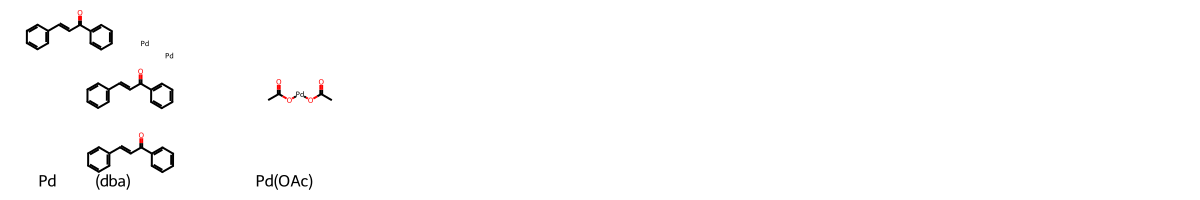

In [ ]:
uru.rd_make_structures_pretty()
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in Pd_Source.values()],molsPerRow=6,
                          legends=Pd_Source.keys())

In [ ]:
Base = {'NaOtBu': '[Na+].CC(C)([O-])C',
#        'KOtBu': '[K+].CC(C)([O-])C',
        'K₃PO₄': '[K+].[K+].[K+].[O-]P([O-])([O-])=O',
        'Cs₂CO₃': '[Cs+].[Cs+].[O-]C([O-])=O'}
#        'NaH': '[Na-].[H+]',
#        'DBU': 'N1=C(NCCCCC1)C=C2CCCCC2',
#        'DIPEA': 'CCN(CC)C(C)C'}

In [ ]:
Ligand = {'BrettPhos': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC',
 'PPht-Bu2': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C',
 't-BuPh-CPhos': 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3',
 'GPhos': 'COC1=CC=C(C=C1OC)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC(C)C)=CC=C2OC(C)C',
 'RuPhos': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC',
# 'PCy3': 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3',
# 'PPH3': 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3',
 'XPhos': 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C',
# 'P(fur)3': 'P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3',
# 'PPh2Me': 'CP(C1=CC=CC=C1)C2=CC=CC=C2',
# 'GlorPhos': 'CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C',
# 'JackiePhos': 'FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1',
# 'CgMe-PPh': 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1',
# 'PPhMe2': 'CP(C)C1=CC=CC=C1',
  'PPh-t-Bu₂': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C'}

We can use the RDKit to draw the structures of the ligands.  The function **rd_make_structures_pretty** from the [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils) library adjusts a few settings to make the RDKit structure drawings look better.

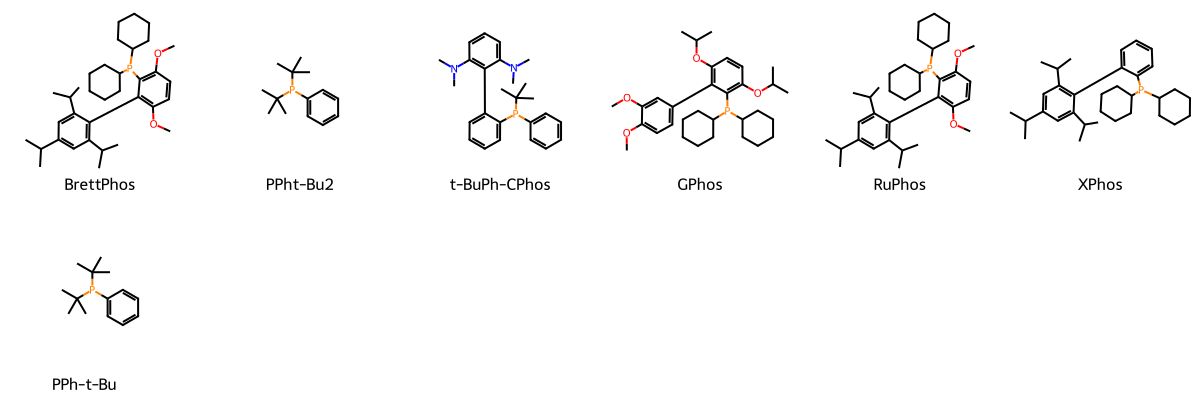

In [ ]:
uru.rd_make_structures_pretty()
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in Ligand.values()],molsPerRow=6,
                          legends=Ligand.keys())

In the next few cells, we define the possible choices for solvent, concentration, and temperature.

In [ ]:
Solvent = {'DMAc': 'CC(N(C)C)=O',
 'tBuOH': 'CC(C)(C)O',
 'Toluene': 'Cc1ccccc1'}
# 'BuCN': 'CCCC#N',
# 'BuOAc': 'CCOC(=O)C',
# 'p-Xylene': 'CC1=CC=C(C)C=C1'}

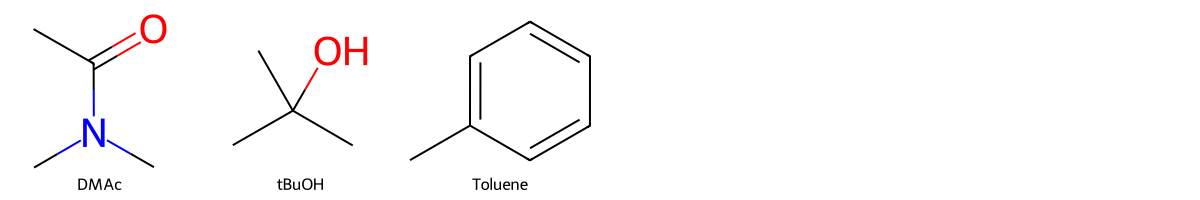

In [ ]:
uru.rd_make_structures_pretty()
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in Solvent.values()],molsPerRow=6,
                          legends=Solvent.keys())

The next are **numeric parameters**, so we can simply define these as lists.

In [ ]:
Temp_C = [80, 100.0, 120.0]
Time_h = [1, 6, 12]
Percent_Pd = [1, 3, 5]
Stoichiometry_ArX = [1, 1.2]
Stoichiometry_Base = [1, 2, 3]

After parsing the input data, we use the corresponding values to define parameters.  As mentioned above, the first three are of type **[CategoricalParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#categoricalparameter)** and the next two are of type **[NumericalDiscreteParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#numericaldiscreteparameter)**.

In [ ]:
ohe_base_param = CategoricalParameter(values=Base.keys(), name="Base_Name")
print(f"Number of values for Base_Name: {len(Base.keys())}")
ohe_ligand_param = CategoricalParameter(values=Ligand.keys(),name="Ligand_Name")
print(f"Number of values for Ligand_Name: {len(Ligand.keys())}")
ohe_solvent_param = CategoricalParameter(values=Solvent.keys(),name="Solvent_Name")
print(f"Number of values for Solvent_Name: {len(Solvent.keys())}")
ohe_temp_param = NumericalDiscreteParameter(values=Temp_C,name="Temp_C")
print(f"Number of values for Temp_C: {len(Temp_C)}")
ohe_time_param = NumericalDiscreteParameter(values=Time_h, name="Time_h")
print(f"Number of values for Time_h: {len(Time_h)}")
ohe_pd_param = NumericalDiscreteParameter(values=Percent_Pd, name="Percent_Pd")
print(f"Number of values for Percent_Pd: {len(Percent_Pd)}")
ohe_stoichiometry_base_param = NumericalDiscreteParameter(values=Stoichiometry_Base, name="Stoichiometry_Base")
print(f"Number of values for Stoichiometry_Base: {len(Stoichiometry_Base)}")

total_combinations = len(Base.keys()) * len(Ligand.keys()) * len(Solvent.keys()) * len(Temp_C) * len(Time_h) * len(Percent_Pd) * len(Stoichiometry_Base)
print(f"Total number of possible condition combinations: {total_combinations}")

Number of values for Base_Name: 3
Number of values for Ligand_Name: 7
Number of values for Solvent_Name: 3
Number of values for Temp_C: 3
Number of values for Time_h: 3
Number of values for Percent_Pd: 3
Number of values for Stoichiometry_Base: 3
Total number of possible condition combinations: 5103


The number 5103 represents the estimated **total number of possible combinations in your search space**.

After defining each of the individual parameters, the parameters are combined into a list `ohe_parameters` , which is then used to **define the search space** `ohe_searchspace` for the Bayesian Optimisation algorthm.

In [ ]:
ohe_parameters = [ohe_base_param, ohe_ligand_param, ohe_solvent_param, ohe_temp_param, ohe_time_param, ohe_pd_param, ohe_stoichiometry_base_param]

### 2. Define the Searchspace
This parameter list is then used to generate the **[Searchspace](https://emdgroup.github.io/baybe/stable/userguide/searchspace.html)**.

In [ ]:
ohe_searchspace = SearchSpace.from_product(ohe_parameters)

BayBE has a utility method [estimate_product_space_size](https://emdgroup.github.io/baybe/stable/userguide/utils.html#search-space-memory-estimation) that can be used to estimate the size and memory requirements for the SearchSpace.  I like to use this as a quick check to ensure that I've defined the searchspace correctly.

In [ ]:
ohe_searchspace.estimate_product_space_size(ohe_parameters)

MemorySize(exp_rep_bytes=np.float64(1148904.0), exp_rep_shape=(5103, 7), comp_rep_bytes=694008, comp_rep_shape=(5103, 17))

### 3. Define the Target
In this case our **[Target](https://emdgroup.github.io/baybe/stable/userguide/targets.html)** is the yield.  We are only optimizing a single objective so we will use the BayBE **[SingleTargetOjective](https://emdgroup.github.io/baybe/stable/userguide/objectives.html#singletargetobjective)**. Note that we set **mode** to **MAX** indicating that we want to maximize the yield.

In [ ]:
ohe_target = NumericalTarget(name="yield", mode="MAX")
ohe_objective = SingleTargetObjective(ohe_target)

/usr/local/lib/python3.12/dist-packages/baybe/targets/numerical.py:139: DeprecationWarning: Creating numerical targets by specifying MAX/MIN/MATCH modes has been deprecated. For now, you do not need to change your code as we automatically converted your target to the new format. However, this functionality will be removed in a future version, so please familiarize yourself with the new interface.
  warnings.warn(


### 4. Define the Recommender
The [**Recommender**](https://emdgroup.github.io/baybe/stable/userguide/recommenders.html) selects the next set of experiments to try.  Note that we have configured **initial_recommender=FPSRecommender()**.  In this case, if there is no data available, the recommender uses **[farthest point sampling](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender.html#baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender)** to select a diverse set of conditions.  If data is available, the Bayesian **[BotorchRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html#baybe.recommenders.pure.bayesian.botorch.BotorchRecommender)** is used to balance exploration and exploitation and select the next set of reaction conditions.

In [ ]:
ohe_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
)

### 5. Define the Campaign
The Searchspace, Objective and Recommender are combined to produce a **[Campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html)**, which is used to suggest experiments and take in experimental data.  The Campaign has two primary methods: **[recommend](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#getting-recommendations)**, which provides suggested reaction conditions, and **[add_measurements](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#adding-measurements)**, which takes in experimental data and updates the Bayesian model.

In [ ]:
ohe_campaign = Campaign(ohe_searchspace, ohe_objective, ohe_recommender)

### 1. Initial Screening.
Now that the Campaign is defined, we can ask it for recommendations. So far, we haven't done any experiments. As such, the Campaign will use farthest point sampling to select a diverse set of initial conditions.

An initial screening is conducted to feed the Bayesian Optimization model predictions.

In [ ]:
ohe_rec_1 = ohe_campaign.recommend(10)
ohe_rec_1

,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
0,Cs₂CO₃,BrettPhos,DMAc,80.0,1.0,1.0,1.0
2105,K₃PO₄,GPhos,Toluene,120.0,12.0,5.0,3.0
4851,NaOtBu,XPhos,tBuOH,120.0,12.0,1.0,1.0
1160,Cs₂CO₃,RuPhos,tBuOH,80.0,12.0,5.0,3.0
3971,NaOtBu,PPh-t-Bu₂,Toluene,80.0,1.0,1.0,3.0
4921,NaOtBu,t-BuPh-CPhos,DMAc,120.0,1.0,5.0,2.0
2625,K₃PO₄,PPht-Bu2,tBuOH,100.0,1.0,5.0,1.0
2745,K₃PO₄,RuPhos,DMAc,120.0,12.0,1.0,1.0
2933,K₃PO₄,XPhos,DMAc,80.0,6.0,5.0,3.0
806,Cs₂CO₃,PPht-Bu2,DMAc,120.0,12.0,3.0,3.0


### Perform Experiments
We typically perform a set of experiments using the 10 recommendations provided by the Campaign.

In [ ]:
#@title Manually add the yields for our initial 10 recommended conditions (Batch 1)
ohe_rec_1['yield'] = [
# Add the yield values here, for example:
    12,
    0,
    0,
    17,
    33,
    53,
    24.,
    10,
    5,
    0,
]
display(ohe_rec_1.style.set_caption("Edit the 'yield' column with your experimental results"))
ohe_rec_1.to_csv('ohe_rec_1.csv', index=False)

,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base,yield
0,Cs₂CO₃,BrettPhos,DMAc,80.000000,1.000000,1.000000,1.000000,12.000000
2105,K₃PO₄,GPhos,Toluene,120.000000,12.000000,5.000000,3.000000,0.000000
4851,NaOtBu,XPhos,tBuOH,120.000000,12.000000,1.000000,1.000000,0.000000
1160,Cs₂CO₃,RuPhos,tBuOH,80.000000,12.000000,5.000000,3.000000,17.000000
3971,NaOtBu,PPh-t-Bu₂,Toluene,80.000000,1.000000,1.000000,3.000000,33.000000
4921,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,5.000000,2.000000,53.000000
2625,K₃PO₄,PPht-Bu2,tBuOH,100.000000,1.000000,5.000000,1.000000,24.000000
2745,K₃PO₄,RuPhos,DMAc,120.000000,12.000000,1.000000,1.000000,10.000000
2933,K₃PO₄,XPhos,DMAc,80.000000,6.000000,5.000000,3.000000,5.000000
806,Cs₂CO₃,PPht-Bu2,DMAc,120.000000,12.000000,3.000000,3.000000,0.000000


Now that we've performed the initial experiments, we need to add the data from the experiments to the Campaign.  We do this with the **add_measurements** method.

In [ ]:
# Load the data from the CSV file with manually added yields
ohe_rec_1_with_yields = pd.read_csv('/content/ohe_rec_1.csv')

# Add the measurements to the campaign
ohe_campaign.add_measurements(ohe_rec_1_with_yields)

In [ ]:
# Remove the loop to handle manual yield entry for each round
# for i in tqdm(range(0,5)):
#     rec = ohe_campaign.recommend(5)
#     rec_results = reaction_lookup.lookup_yields_from_Name(rec)
#     if not rec_results.empty:
#         ohe_campaign.add_measurements(rec_results)
#     else:
#         print(f"No matching conditions found in the lookup table for batch {i+2}. Skipping adding measurements for this batch.")

# Recommend the next 5 conditions
recommended_conditions = ohe_campaign.recommend(5)

print("Recommended conditions for the next round:")
display(recommended_conditions.style.set_caption("Manually add 'yield' column and values in the next cell"))

Recommended conditions for the next round:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
index,,,,,,,
4930,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,6.000000,5.000000,2.000000
4894,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,1.000000,5.000000,2.000000
4920,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,5.000000,1.000000
4922,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,5.000000,3.000000
4918,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,3.000000,2.000000


Add the yields from these recommeneded experiments (5 recommended conditions):

In [ ]:
recommended_conditions['yield'] = [
    # Add the 5 yield values here, corresponding to the recommended conditions:
    22,
    33,
    10,
    54,
    75
]

# Add the recommended conditions with yields to the campaign
ohe_campaign.add_measurements(recommended_conditions)

print("Measurements added to the campaign.")

Measurements added to the campaign.


/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['yield']. Converting to float internally.
  warnings.warn(


Now recommend the next five conditions as input for Round 2 of experiments.

In [ ]:
# Recommend the next 5 conditions
recommended_conditions = ohe_campaign.recommend(5)

print("Recommended conditions for the next round:")
display(recommended_conditions.style.set_caption("Manually add 'yield' column and values in the next cell"))

Recommended conditions for the next round:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
index,,,,,,,
4915,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,1.000000,2.000000
4919,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,3.000000,3.000000
4888,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,1.000000,1.000000,2.000000
4916,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,1.000000,1.000000,3.000000
4892,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,1.000000,3.000000,3.000000


Add the yields from the second round of optimisation experiments (5 recommended conditions):

In [ ]:
# Manually add the yield values for the recommended conditions
recommended_conditions['yield'] = [
    4,
    0,
    55,
    78,
    75
]

# Add the recommended conditions with yields to the campaign
ohe_campaign.add_measurements(recommended_conditions)

print("Measurements added to the campaign.")

Measurements added to the campaign.


/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['yield']. Converting to float internally.
  warnings.warn(


Recommend the next five conditions as input for the third round of experiments.

In [ ]:
# Recommend the next 5 conditions
recommended_conditions = ohe_campaign.recommend(5)

print("Recommended conditions for the next round:")
display(recommended_conditions.style.set_caption("Manually add 'yield' column and values in the next cell"))

Recommended conditions for the next round:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
index,,,,,,,
4925,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,6.000000,1.000000,3.000000
4901,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,6.000000,3.000000,3.000000
4927,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,6.000000,3.000000,2.000000
4897,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,6.000000,1.000000,2.000000
4931,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,6.000000,5.000000,3.000000


In [ ]:
# Manually add the yield values for the recommended conditions
recommended_conditions['yield'] = [
    80,
    82,
    90,
    78,
    82
]

# Add the recommended conditions with yields to the campaign
ohe_campaign.add_measurements(recommended_conditions)

print("Measurements added to the campaign.")

Measurements added to the campaign.


/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['yield']. Converting to float internally.
  warnings.warn(


Recommend the next five conditions as input for Round Four of experiments.

In [ ]:
# Recommend the next 5 conditions
recommended_conditions = ohe_campaign.recommend(5)

print("Recommended conditions for the next round:")
display(recommended_conditions.style.set_caption("Manually add 'yield' column and values in the next cell"))

Recommended conditions for the next round:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
index,,,,,,,
4940,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,12.000000,5.000000,3.000000
4936,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,12.000000,3.000000,2.000000
4906,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,12.000000,1.000000,2.000000
4910,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,12.000000,3.000000,3.000000
4934,NaOtBu,t-BuPh-CPhos,DMAc,120.000000,12.000000,1.000000,3.000000


In [ ]:
# Manually add the yield values for the recommended conditions
recommended_conditions['yield'] = [
    88,
    68,
    55,
    0,
    93
]

# Add the recommended conditions with yields to the campaign
ohe_campaign.add_measurements(recommended_conditions)

print("Measurements added to the campaign.")

Measurements added to the campaign.


/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['yield']. Converting to float internally.
  warnings.warn(


Recommend the next five conditions as input for Round 5.

In [ ]:
# Recommend the next 5 conditions
recommended_conditions = ohe_campaign.recommend(5)

print("Recommended conditions for the next round:")
display(recommended_conditions.style.set_caption("Manually add 'yield' column and values in the next cell"))

Recommended conditions for the next round:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
index,,,,,,,
4898,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,6.000000,1.000000,3.000000
4900,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,6.000000,3.000000,2.000000
4904,NaOtBu,t-BuPh-CPhos,DMAc,100.000000,6.000000,5.000000,3.000000
4870,NaOtBu,t-BuPh-CPhos,DMAc,80.000000,6.000000,1.000000,2.000000
4865,NaOtBu,t-BuPh-CPhos,DMAc,80.000000,1.000000,3.000000,3.000000


Next, let's compare the yield values over the six optimization cycles. We can ask the Campaign to provide a table with the measurements.  Note that the dataframe returned has a column **BatchNr** indicating the optimization cycle.

In [ ]:
#@title Overall results
ohe_measurement_df = ohe_campaign.measurements
ohe_measurement_df

,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base,yield,BatchNr,FitNr
0,Cs₂CO₃,BrettPhos,DMAc,80.0,1.0,1.0,1.0,12.0,1,1.0
1,K₃PO₄,GPhos,Toluene,120.0,12.0,5.0,3.0,0.0,1,1.0
2,NaOtBu,XPhos,tBuOH,120.0,12.0,1.0,1.0,0.0,1,1.0
3,Cs₂CO₃,RuPhos,tBuOH,80.0,12.0,5.0,3.0,17.0,1,1.0
4,NaOtBu,PPh-t-Bu₂,Toluene,80.0,1.0,1.0,3.0,33.0,1,1.0
5,NaOtBu,t-BuPh-CPhos,DMAc,120.0,1.0,5.0,2.0,53.0,1,1.0
6,K₃PO₄,PPht-Bu2,tBuOH,100.0,1.0,5.0,1.0,24.0,1,1.0
7,K₃PO₄,RuPhos,DMAc,120.0,12.0,1.0,1.0,10.0,1,1.0
8,K₃PO₄,XPhos,DMAc,80.0,6.0,5.0,3.0,5.0,1,1.0
9,Cs₂CO₃,PPht-Bu2,DMAc,120.0,12.0,3.0,3.0,0.0,1,1.0


In [ ]:
# Find the maximum yield
max_yield = ohe_measurement_df['yield'].max()

# Get all rows that have the maximum yield
highest_yield_conditions = ohe_measurement_df[ohe_measurement_df['yield'] == max_yield]

print(f"The highest yield achieved is: {max_yield}")
print("The reaction conditions that resulted in this yield are:")
display(highest_yield_conditions.drop(columns=['yield', 'BatchNr', 'FitNr']))


The highest yield achieved is: 93.0
The reaction conditions that resulted in this yield are:


,Base_Name,Ligand_Name,Solvent_Name,Temp_C,Time_h,Percent_Pd,Stoichiometry_Base
29,NaOtBu,t-BuPh-CPhos,DMAc,120.0,12.0,1.0,3.0


To get an idea of how the reaction yields improve over multiple cycles, we can plot **yield** as a function of **batch number**.  Since the Bayesian Optimization routine balances exploration and exploitation, it can happen that later batches contain recommendations with lower yields that previous batches.

<Axes: xlabel='BatchNr', ylabel='yield'>

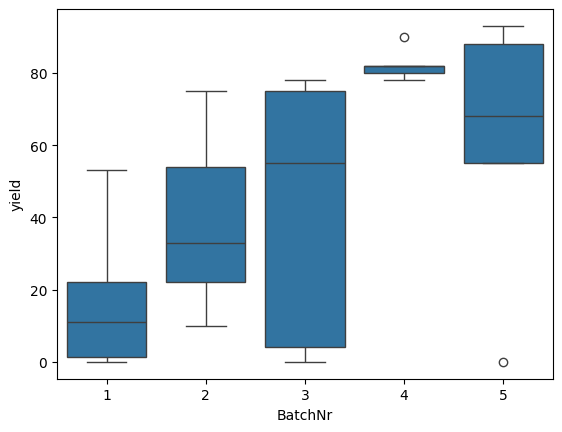

In [ ]:
sns.boxplot(x="BatchNr",y="yield",data=ohe_measurement_df)

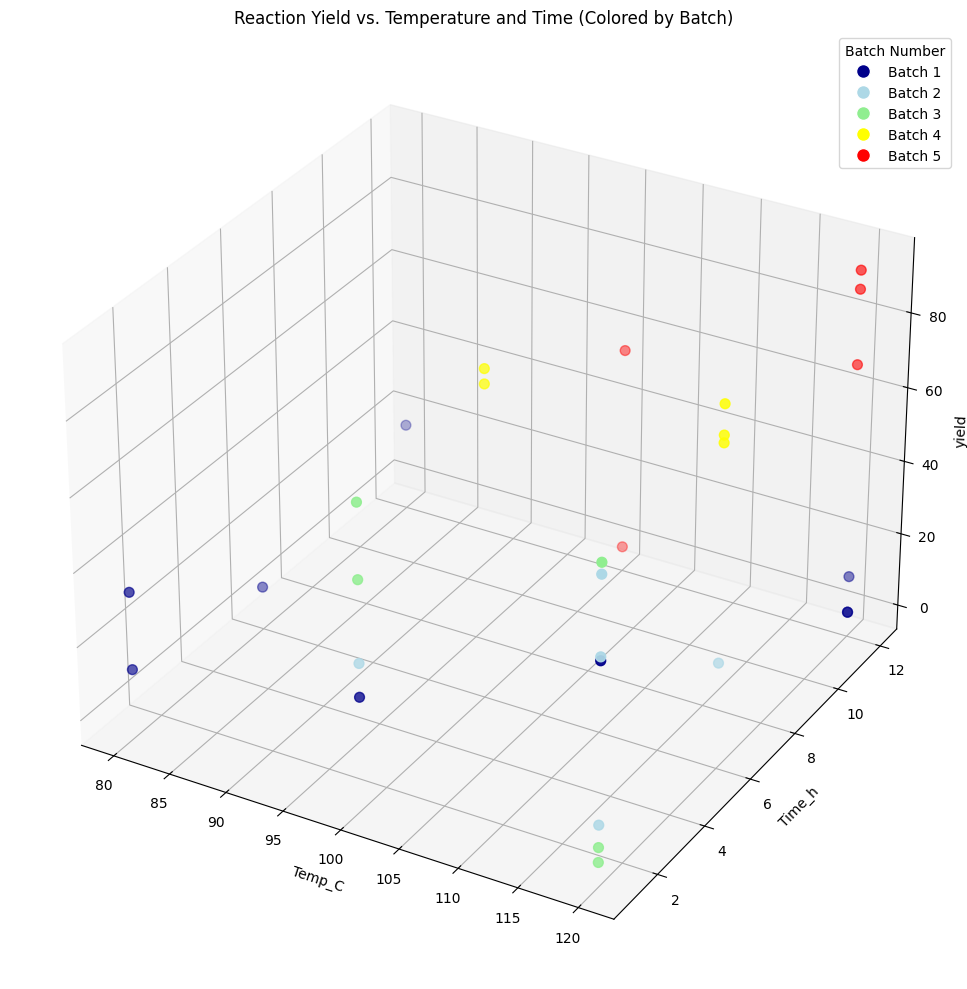

In [ ]:
#@title 3D Scatter Plot - Colored by Batch Number
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np # Import numpy


# Get all measurements from the campaign
all_measurements = ohe_campaign.measurements

# Extract the relevant columns from all measurements
x1_data = all_measurements['Temp_C']
x2_data = all_measurements['Time_h']
y_data = all_measurements['yield']
batch_data = all_measurements['BatchNr']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10)) # Increased figure size for better visibility
ax = fig.add_subplot(111, projection='3d')

# Define the specific colors for each batch number
batch_color_map = {
    1: 'darkblue',
    2: 'lightblue',
    3: 'lightgreen',
    4: 'yellow',
    5: 'red'
}

# Create a list of colors for each data point based on its batch number
point_colors = [batch_color_map.get(batch, 'gray') for batch in batch_data] # Use gray for any batches not specified


# Scatter plot with colors based on batch number
scatter = ax.scatter(x1_data, x2_data, y_data, c=point_colors, marker='o', s=50) # Increased marker size

ax.set_xlabel('Temp_C')
ax.set_ylabel('Time_h')
ax.set_zlabel('yield')
ax.set_title('Reaction Yield vs. Temperature and Time (Colored by Batch)')

# Create a legend using the specified colors and batch numbers present in the data
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'Batch {batch}',
               markerfacecolor=batch_color_map[batch], markersize=10)
    for batch in sorted(batch_data.unique()) if batch in batch_color_map # Only include batches present and with defined colors
]
ax.legend(handles=legend_elements, title="Batch Number")

fig.tight_layout()

plt.show()

RDKit: 2025.09.1


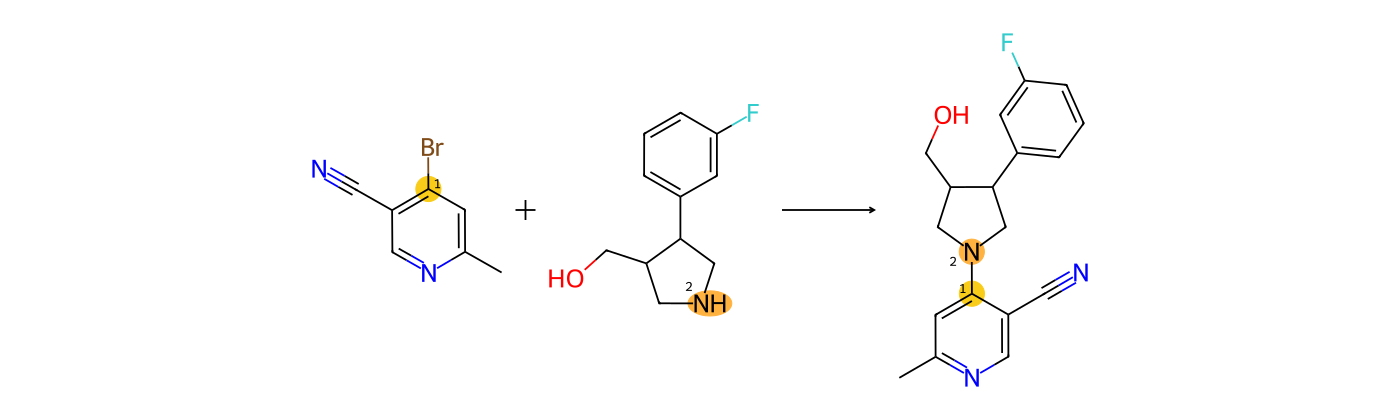

✅ Wrote 'reaction_highlight.svg' (vector) and 'reaction_highlight.png' (hi-res PNG).


In [ ]:
#@title Displaying atom maps and highlighting with reactions
# adapted from https://greglandrum.github.io/rdkit-blog/posts/2025-10-17-displaying-atom-maps-with-reactions.html

from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Geometry import Point2D # Corrected import for Point2D
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display, Image as IPyImage
import rdkit
print("RDKit:", rdkit.__version__)

# --- Your reactants ---
r1 = Chem.MolFromSmiles("OCC1CNCC1c2cccc(F)c2")   # secondary amine (has N–H)
r2 = Chem.MolFromSmiles("Cc1cc(Br)c(C#N)cn1")     # aryl bromide

# --- Buchwald–Hartwig amination SMARTS (map only atoms that persist; no map on Br) ---
sma = "[c:1]-Br.[N;H1:2]>>[c:1]-[N:2]"
rxn = rdChemReactions.ReactionFromSmarts(sma)

# --- Run reaction; try both orders if needed ---
prods = rxn.RunReactants((r1, r2))
reacts = (r1, r2)
if not prods:
    prods = rxn.RunReactants((r2, r1))
    reacts = (r2, r1)
if not prods:
    raise ValueError("Reaction SMARTS did not match these reactants. "
                     "Consider relaxing the SMARTS (e.g. [N;H1,H0:2]).")

# --- Helper: build a draw-ready reaction with reactant-based highlights (Greg’s approach) ---
def prepare_draw_reaction(rxn, reacts, prods, includeAtomMaps=True, mapAllAtoms=False):
    reacts = [Chem.Mol(r) for r in reacts]
    prods  = [Chem.Mol(p) for p in prods]
    negVal = -1
    if mapAllAtoms:
        for prod in prods:
            for at in prod.GetAtoms():
                if at.HasProp('old_mapno'):
                    negVal = min(negVal, -1 * at.GetIntProp('old_mapno')) - 1
    # transfer mapping/meta from product atoms to product and corresponding reactant atoms
    for prod in prods:
        for at in prod.GetAtoms():
            pd = at.GetPropsAsDict()
            mno = pd.get('old_mapno', 0 if not mapAllAtoms else negVal)
            if mno != 0:
                rat = reacts[pd['react_idx']].GetAtomWithIdx(pd['react_atom_idx'])
                for tat in (at, rat):
                    tat.SetAtomMapNum(mno)
                    if includeAtomMaps:
                        tat.SetProp('atomNote', str(mno))
    nrxn = rdChemReactions.ChemicalReaction()
    for r in reacts: nrxn.AddReactantTemplate(r)
    for p in prods:  nrxn.AddProductTemplate(p)
    return nrxn

nrxn = prepare_draw_reaction(rxn, reacts, prods[0], includeAtomMaps=True, mapAllAtoms=False)

# --- Choose distinct reactant highlight colors (RGB 0–1) ---
colors = [(0.98, 0.80, 0.10),  # yellow
          (1.00, 0.70, 0.25)]  # orange

# Retrieve optimal conditions from the dataframe
optimal_conditions_data = highest_yield_conditions.drop(columns=['yield', 'BatchNr', 'FitNr']).iloc[0]

optimal_conditions_text = f"Optimal Conditions (Yield: {max_yield}%):\n" \
                          f"Base: {optimal_conditions_data['Base_Name']}, Ligand: {optimal_conditions_data['Ligand_Name']}, Solvent: {optimal_conditions_data['Solvent_Name']}\n" \
                          f"Temp: {optimal_conditions_data['Temp_C']} °C, Time: {optimal_conditions_data['Time_h']} h, Percent Pd: {optimal_conditions_data['Percent_Pd']}, Stoichiometry Base: {optimal_conditions_data['Stoichiometry_Base']}"


# ========= SVG (vector; never blurry) =========
svg_w, svg_h = 1400, 420           # adjust size as desired
dsvg = rdMolDraw2D.MolDraw2DSVG(svg_w, svg_h)
dopt = dsvg.drawOptions()
dopt.fixedBondLength = 42.0        # controls molecule size (px per bond)
dopt.bondLineWidth   = 1.8
dopt.minFontSize     = 12
dopt.padding         = 0.04
dsvg.DrawReaction(nrxn, highlightByReactant=True,
                  highlightColorsReactants=colors)

# Add optimal conditions text for SVG
text_lines_svg = optimal_conditions_text.split('\n')
# Adjust y position to be above the reaction arrow, assuming arrow is roughly in the middle
text_y_start_svg = (svg_h / 2) - (len(text_lines_svg) * dopt.minFontSize * 1.2) # Adjusted based on font size

for i, line in enumerate(text_lines_svg):
    # dsvg.DrawString(line, (svg_w / 2, text_y_start_svg + i * font_size_svg * 1.2), font_size=font_size_svg, font_name="sans", anchor="middle") # Original problematic line
    dsvg.DrawString(line, Point2D(svg_w / 2, text_y_start_svg + i * dopt.minFontSize * 1.2), 1) # Use 1 for center alignment

dsvg.FinishDrawing()
svg_text = dsvg.GetDrawingText()

# Display & save SVG
display(SVG(svg_text))
with open("reaction_highlight.svg", "w") as f:
    f.write(svg_text)

# ========= High-res PNG (great for slides) =========
png_w, png_h = 2800, 840           # 2× the SVG canvas → very crisp PNG
dpng = rdMolDraw2D.MolDraw2DCairo(png_w, png_h)
popt = dpng.drawOptions()
popt.fixedBondLength = 42.0
popt.bondLineWidth   = 2.2
popt.minFontSize     = 14
popt.padding         = 0.04
dpng.DrawReaction(nrxn, highlightByReactant=True,
                  highlightColorsReactants=colors)

# Add optimal conditions text for PNG
text_lines_png = optimal_conditions_text.split('\n')
# Adjust y position to be above the reaction arrow, assuming arrow is roughly in the middle
text_y_start_png = (png_h / 2) - (len(text_lines_png) * popt.minFontSize * 1.2) # Adjusted based on font size

for i, line in enumerate(text_lines_png):
    # dpng.DrawString(line, (png_w / 2, text_y_start_png + i * font_size_png * 1.2), font_size=font_size_png, font_name="sans", anchor="middle") # Original problematic line
    dpng.DrawString(line, Point2D(png_w / 2, text_y_start_png + i * popt.minFontSize * 1.2), 1) # Use 1 for center alignment

dpng.FinishDrawing()
png_bytes = dpng.GetDrawingText()

# Display & save PNG
from pathlib import Path
Path("reaction_highlight.png").write_bytes(png_bytes)

print("✅ Wrote 'reaction_highlight.svg' (vector) and 'reaction_highlight.png' (hi-res PNG).")

### Optimizing With Substance Parameters
In the sections above we used One-Hot Encoding to describe our reactants and catalysts. Each of the parameters was simply a label, the optimization process didn't include any notions of chemistry.  BayBE provides another parameter type called a [SubstanceParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#substanceparameter), where chemical entities are described by a set of molecular descriptors.   These descriptors enable the model to attribute similar behaviors to similar chemicals.  In the code block below, we define the base, ligand, and solvent with SubstanceParameters.  Note that this definition is similar to the way we defined the CategoricalParameters above, with two notable exceptions.  
- First we define an encoding, which uses the **[Mordred](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)** descriptor calculator.
- Second, we specify **decorrelate=0.7**, which removes correlated descriptors and makes the calculations more efficient.
  
Note that the concentration and temperature parameters are defined as above.

In [ ]:
substance_base_param = SubstanceParameter(data=Base, name="Base_Name", encoding="MORDRED", decorrelate=0.7)
# Corrected Ligand dictionary to remove duplicate structure entry ('RuPhos' is a duplicate of 'BrettPhos')
Ligand_corrected = {
    'BrettPhos': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC',
    'PPht-Bu2': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C',
    't-BuPh-CPhos': 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3',
    'GPhos': 'COC1=CC=C(C=C1OC)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC(C)C)=CC=C2OC(C)C',
    'XPhos': 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C',
    'PPh-t-Bu₂': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C'
}
substance_ligand_param = SubstanceParameter(data=Ligand_corrected, name="Ligand_Name", encoding="MORDRED", decorrelate=0.7)

substance_solvent_param = SubstanceParameter(data=Solvent, name="Solvent_Name",encoding="MORDRED",decorrelate=0.7)

# Define Concentration as a list
Concentration = [0.057, 0.100, 0.153] # Add example values for Concentration
concentration_param = NumericalDiscreteParameter(values=Concentration,name="Concentration")

temp_param = NumericalDiscreteParameter(values=Temp_C,name="Temp_C")

substance_params = [substance_base_param, substance_ligand_param, substance_solvent_param, concentration_param, temp_param]

ExceptionGroup: duplicate substances (1 sub-exception)

The Searchspace, Target, and Recommender are defined as above.

In [ ]:
substance_searchspace = SearchSpace.from_product(substance_params)

NameError: name 'substance_params' is not defined

In [ ]:
substance_target = NumericalTarget(name="yield", mode="MAX")
substance_objective = SingleTargetObjective(substance_target)

/usr/local/lib/python3.12/dist-packages/baybe/targets/numerical.py:139: DeprecationWarning: Creating numerical targets by specifying MAX/MIN/MATCH modes has been deprecated. For now, you do not need to change your code as we automatically converted your target to the new format. However, this functionality will be removed in a future version, so please familiarize yourself with the new interface.
  warnings.warn(


In [ ]:
substance_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
)

Combine the Searchspace, Objective, and Recommender to generate a Campaign.

In [ ]:
substance_campaign = Campaign(substance_searchspace, substance_objective, substance_recommender)

NameError: name 'substance_searchspace' is not defined

Get the initial recommendation using farthest point sampling.

In [ ]:
substance_rec_1 = substance_campaign.recommend(10)

NameError: name 'substance_campaign' is not defined

In [ ]:
substance_rec_1

NameError: name 'substance_rec_1' is not defined

Look up the yields for the initial 10 recommendations.

In [ ]:
substance_rec_1_results = reaction_lookup.lookup_yields_from_Name(substance_rec_1)

In [ ]:
substance_rec_1_results

,Base_Name,Ligand_Name,Solvent_Name,Concentration,Temp_C,yield
0,KOAc,PPH3,p-Xylene,0.100,120,5.94
1,KOPv,XPhos,BuCN,0.057,90,30.83
2,CsOPv,PPht-Bu2,p-Xylene,0.057,90,0.00
3,KOPv,t-BuPh-CPhos,BuOAc,0.057,120,3.88
4,CsOAc,BrettPhos,DMAc,0.153,90,6.26
5,KOPv,PCy3,BuOAc,0.153,120,0.00
6,CsOPv,P(fur)3,DMAc,0.057,90,21.65
7,CsOAc,PPhMe2,BuCN,0.057,90,0.00
8,CsOAc,JackiePhos,p-Xylene,0.057,90,5.48
9,KOAc,CgMe-PPh,p-Xylene,0.153,120,60.29


In [ ]:
substance_campaign.add_measurements(substance_rec_1_results)

/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  warnings.warn(


Perform an additional 5 rounds of optimization, looking up experimental values for the reaction yields.

In [ ]:
for i in tqdm(range(0,5)):
    substance_rec = substance_campaign.recommend(5)
    substance_rec_results = reaction_lookup.lookup_yields_from_Name(substance_rec)
    substance_campaign.add_measurements(substance_rec_results)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/baybe/utils/dataframe.py:749: InputDataTypeWarning: The following columns have unexpected data types: ['Temp_C']. Converting to float internally.
  

In [ ]:
substance_measurement_df = substance_campaign.measurements

To get an idea of how the reaction yields improve over multiple cycles, we can plot **yield** as a function of **batch number**.  

In [ ]:
sns.boxplot(x="BatchNr",y="yield",data=substance_measurement_df)

NameError: name 'substance_measurement_df' is not defined

### Assessing Feature Importance with BayBE Insights
BayBE also has the ability to [assess the importance of features](https://emdgroup.github.io/baybe/stable/userguide/insights.html) to the model.  This capability uses the [SHAP](https://shap.readthedocs.io/en/latest/) library for interpreting machine learning models. A larger SHAP value indicates that a feature has a larger impact on the model predictions.

In [ ]:
insight = SHAPInsight.from_campaign(substance_campaign)

In [ ]:
insight.plot("bar")

NameError: name 'insight' is not defined

BayBE also supports a **beeswarm plot** where each point represents a set of reaction conditions.  Colors are used to represent the values of numeric parameters.  In the plot below, we see that we have higher SHAP values for higher temperatures and concentrations.

  0%|          | 0/35 [00:00<?, ?it/s]

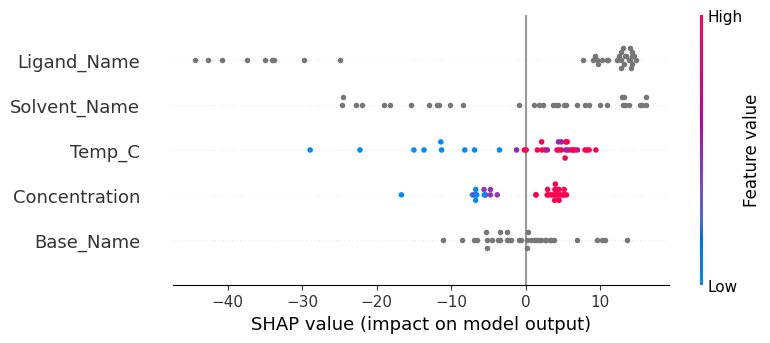

In [ ]:
insight.plot("beeswarm")

We can also pass a dataset as the second argument to **[insight.plot](https://emdgroup.github.io/baybe/stable/userguide/insights.html#plots)** and examine a single interation.  In the plot below, we only look at the first example. In this case we use a force plot, which uses the analogy of forces to illustrate how different features contribute to a model's output for a specific instance.
- The **base value** is the mean value for all instances
- **f(x)** shows the value for this instance
- Values in red indicate parameters that increase the yield
- Values in blue indicate parameters that decrease the yield
- The size of each feature's contribution is indicated by the width of its corresponding section in the plot

  0%|          | 0/1 [00:00<?, ?it/s]

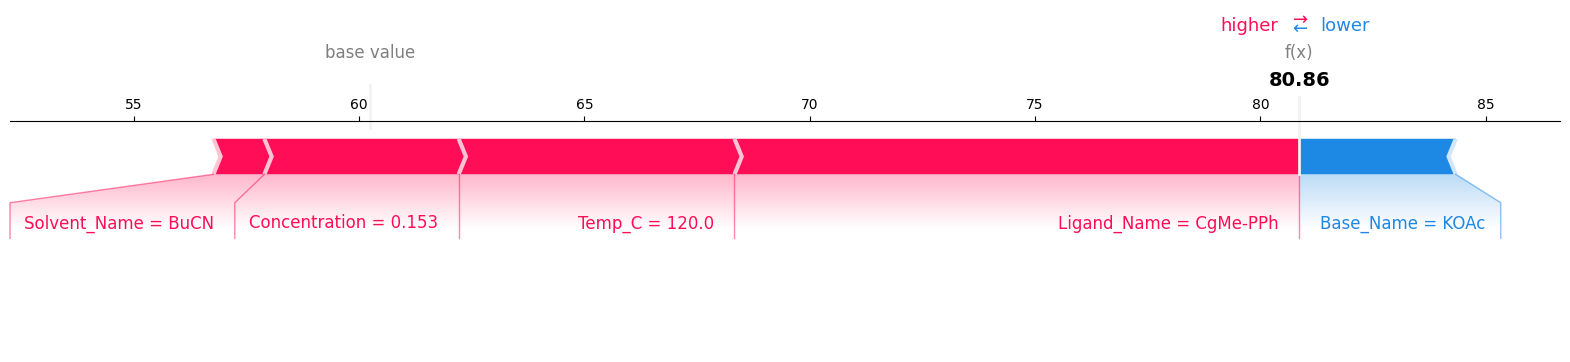

In [ ]:
insight.plot("force",explanation_index=12)

Resources for Bayesian Optimisation:

[Introduction to Bayesian Optimisation](https://www.youtube.com/watch?v=_RMY9W1RPzE)

[GPSS2024 Bayesian Optimization and Beyond](https://www.youtube.com/watch?v=fxQPsfPWVKQ&list=PLZ_xn3EIbxZEoWLlm9y6OizFkontrhA6G&index=7)

https://bayesoptbook.com/